In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.linalg import eigh
from scipy import spatial
from sklearn import datasets
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.decomposition import PCA


# Assignment 2

# PCA, eigenfaces and face recognition 


Face perception is very important in human social interactions. It is facilitated by complex neuronal interactions utilizing extensive and diverse areas of the brain in order to support the sophisticated cognitive skills, including recognition of familiar faces, identification of diverse facial expressions and interpretation of emotions.

In signal processing, manipulating and interpreting images of human faces also play an important role. This is both in order to simulate the information processing that occur in the brain but also in a wide range of intelligent systems and services, that for instance implements face detection and face recognition.

Face images are very high-dimensional data if we consider each pixel position as a feature. For instance, images with a resolution of $64\times 64$ pixels will have $64 \times 64 = 4096$ dimensions. However, it is easy to realize that only relatively few of the possible high-dimensional images will actually correspond to a possible face, ie. most possible images will not depict a 'real' face.

In this exercise we are interested in finding a more effective representation, based on quantifying the  subspace of possible face images instead of the space of all $64\times 64$  sized images. To identify such a subspace, we will use principal component analysis (PCA) on a dataset of real face images. 
This procedure allows us to capture the directions that describe most of the variance in actual face images, hence effectively reducing the dimensionality to a subspace of the possible ('real looking') faces.
To illustrate this, we use a standard dataset of face images collected at the AT&T Laboratories in
Cambridge between the year 1992 and 1994. The dataset contains 10 grayscaled face images for each of 40 persons (400 images total). All images are $64\times 64$ pixels and the gray scale of each pixel is represented by a real value $[0,1]$. 



# 0. Load the Olivetti data set

Run the following code to load the Olivetti dataset of face images and plot all the images. In general, high quality data would be images that are taken under the same lighting conditions and where facial features (such as eyes, nose and mouth) are aligned across the images. 


- Make sure you understand how the images are represented as columns in a matrix and how each column is reshaped to a $64\times 64$ matrix when displaying the corresponding image.
- Comment on the quality of the images within and between subjects. 

**Answer:**

There are 400 images in the dataset, and each image measures 64 by 64 pixels. The images represent 40 different subjects, and each subject has 10 images taken under several lighting conditions, facial expressions and facial details.

Overall, the dataset has a representation of authentic face images. The images are of high quality and the facial features are clearly visible and distinguishable. But, there still might be slight variations in lighting or in the way the people pose, which can affect the recognition accuracy in certain situations. When comparing different subjects and differences in facial features such as the size of the eyes or the shape of the nose, it is noticeable, making it more challenging to identify individuals.

Shape before reshaping:  (400, 64, 64)
Shape after reshaping:  (400, 4096)


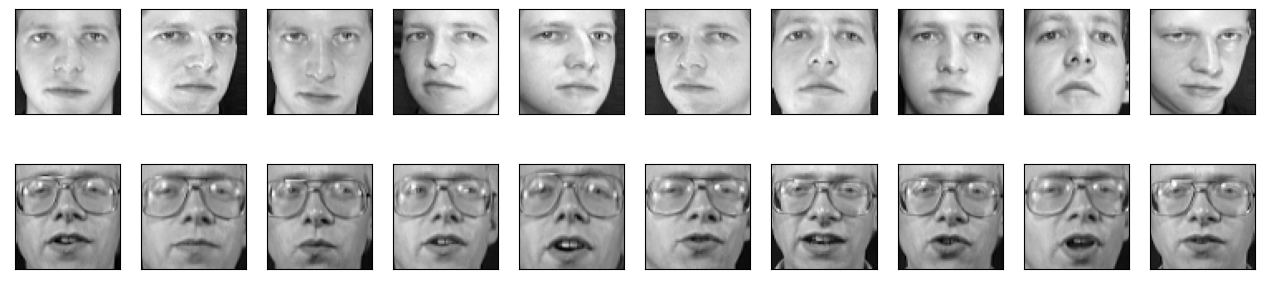

In [2]:
data = datasets.fetch_olivetti_faces()
print("Shape before reshaping: " , np.shape(data.images))
data = data.images.reshape(data.images.shape[0],data.images.shape[1]*data.images.shape[2])
print("Shape after reshaping: " , np.shape(data))
nSubjects = np.shape(data)[0]
labels = np.tile(np.arange(1,41),(10,1)).T.flatten()

fig = plt.figure(figsize=(16,80))
for i in range(20):    
    ax = fig.add_subplot(40,10,i+1,xticks = [], yticks = [])
    image_i = data[i,:]
    ax.imshow(image_i.reshape(64,64), cmap=plt.cm.gray)
plt.show()



# 1 Split data into test and training

To later evaluate the dimensinality reduction and test face recognition, we will split the data-set into a training and test set. We will only perform PCA on the training data. We will later use the test data to examine how well the PCA components can be used for implementing a face recognition system.

$\bullet$ Google "sklearn.model_selection.train_test_split" and read about this function. Use it below to split the data with 25% test. **Make sure you use stratify=labels as argument** for later analysis

In [3]:
X_train, X_test, y_train, y_test = train_test_split(data,labels,stratify=labels,random_state=10, test_size=0.25)

n_train_subjects = np.shape(X_train)[0]
n_test_subjects = np.shape(X_test)[0]
# Check that we have 25 % test:
print(np.shape(X_train), "it should be (300, 4096)")
print(np.shape(X_test), "it should be (100, 4096)")

(300, 4096) it should be (300, 4096)
(100, 4096) it should be (100, 4096)


$\bullet$ Plot both the training and test images. Verify that they are different.

Some training examples...


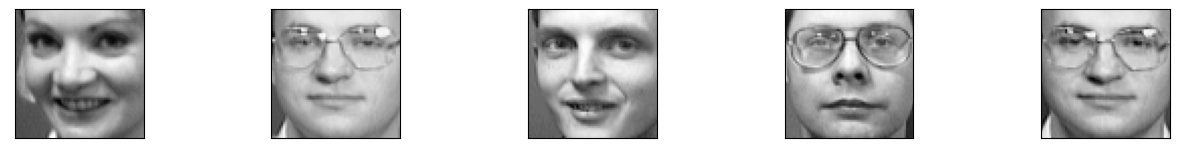

Some test examples...


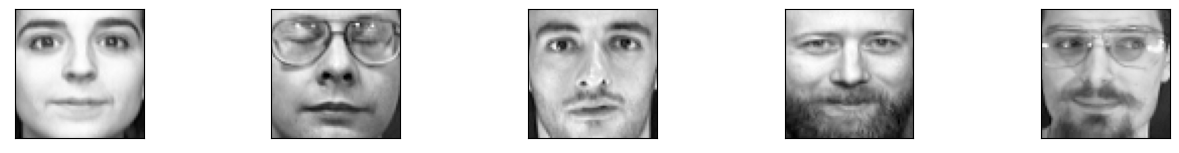

In [4]:
#plot training set
print('Some training examples...')
fig = plt.figure(figsize=(16,80))
for i in range(5):    
    ax = fig.add_subplot(40,5,i+1,xticks = [], yticks = [])
    image_i = X_train[i,:];
    ax.imshow(image_i.reshape(64,64), cmap=plt.cm.gray)
plt.show()
#plot test set
print('Some test examples...')
fig = plt.figure(figsize=(16,80))
for i in range(5):    
    ax = fig.add_subplot(40,5,i+1,xticks = [], yticks = [])
    image_i = X_test[i,:];
    ax.imshow(image_i.reshape(64,64), cmap=plt.cm.gray)
plt.show()    

# 2 Standardizing the data
The purpose of principal component analysis (PCA) is to project the training data onto directions which maximize the variance. Before applying PCA it is custom to standardize the data to avoid that the scales of single features dominate the first principle components.

For face images, standardization is performed by computing the average training image, subtracting it from each of the training images, and dividing by the standard deviation: $$\tilde{\mathbf{x}}_i= \frac{\mathbf{x}_i - \widehat{\mathbf{\mu}}}{\widehat{\mathbf{\sigma}}}$$

Let $\tilde{\mathbf{X}}_\textrm{train}$ be the matrix of the standardized training data, such that each column $i$ represents the standardized image vector. Likewise, let $\tilde{\mathbf{X}}_\textrm{test}$ be the matrix of standardized test data (using the **training** $\mu$ and $\sigma$).

- Compute the average training image, $\widehat{\mathbf{\mu}}$, and plot it as a $64\times 64$ image. Comment on this plot.
- Compute the standard deviation each pixel.
- Standardize the dataset using the above two.


(4096,)
(4096,)


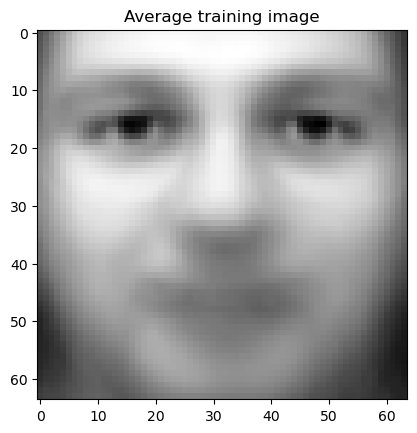

In [5]:
mu          = np.mean(X_train, axis = 0)
std         = np.std(X_train, axis=0)
print(mu.shape) # this should be shape (4096,)
print(std.shape) # this should be shape (4096,)


# Don't change this code
X_train_z   = (X_train - mu)/std
X_test_z    = (X_test - mu)/std

plt.imshow( mu.reshape(64,64),cmap = plt.cm.gray)
plt.title('Average training image')
plt.show()

# 3. Principal component analysis 

Let $\lambda_1,\ldots,\lambda_M$ be the ordered set of eigenvalues of the covariance matrix of the training data, such that $\lambda_1 \geq \lambda_2 \geq \ldots \geq \lambda_M $. If there exists a number $m$, such that $\lambda_i \gg \lambda_j, i = 1,\ldots m$, and $j=m+1,\ldots,M$, then the data-set can be transformed to a coordinate system, where most of the signal variance is in an $m$-dimensional linear subspace spanned by the $m$'th first eigenvectors in the ordered list. Recall that this transformation is given by the eigenvectors $\mathbf{V}=[\mathbf{v}_1 \,\, \mathbf{v}_2 \,\, ... \mathbf{v}_M]$ of the covariance matrix ($\bf \Sigma$):

$$  \mathbf{z}_i = \mathbf{V}^{\top}\tilde{\mathbf{x}}_i. $$

If we extract only the first $m$ components of the transformed datavector $\tilde{\bf x}$ we obtain a signal that carries most of the variation of the original signal.

- Compute the covariance matrix of the normalized training data $\tilde{\mathbf{X}}_\textrm{train}$. You can use the numpy function $\textsf{np.cov}$. Make sure that the data is transposed correctly, such that you obtain the $4096\times 4096$ covariance matrix.

- Compute the eigenvalues and eigenvectors of the covariance matrix. Instead of using numpy's $\textsf{eig}$ function you can use the scipy function $\textsf{eigh}$, which is faster and avoids certain round-off errors under the correct assumption that the covariance matrix is symmetric.

In [6]:
#compute covariance matrix
Sigma           = np.cov(X_train_z.T)
#obtain eigen values and eigen vectors
eigenValues, eigenVectors = eigh(Sigma)

# This code will sort the eigenvalues and eigenvectors for you:
idx_ord         = np.argsort(eigenValues)[::-1]
eigenValues     = eigenValues[idx_ord]
eigenVectors    = eigenVectors[:,idx_ord]

# Check the dimensions
print(Sigma.shape) # this should be shape (4096,4096)
print(eigenValues.shape) # this should be shape (4096,)
print(eigenVectors.shape) # this should be shape (4096,4096)

(4096, 4096)
(4096,)
(4096, 4096)


# 4. Check that your implementation is close to sklearn's:

In [7]:
# Check that your implementation is close to sklearn's implementation:
pca = PCA(n_components=n_train_subjects)
pca.fit(X_train_z)
eigvec_errs = []
eigval_errs = []

for i_c,component in enumerate(pca.components_):
  eigvec_errs.append(np.mean((eigenVectors[i_c]-component)**2))
  eigval_errs.append((eigenValues[i_c]-pca.explained_variance_[i_c])**2)
print("Are your eigenvectors close?",np.isclose(np.mean(eigvec_errs),0,atol=0.001))
print("Are your eigenvalues close?",np.isclose(np.mean(eigval_errs),0,atol=0.001))

Are your eigenvectors close? True
Are your eigenvalues close? True


# 5. For face images **the eigenvectors are referred to as eigenfaces**. They have the same dimensionality as the original images and can hence be plottet as images. 
 
- Examine the most explaining eigenfaces (the eigenvectors with highest eigenvalue) by reshaping and plotting them as $64\times 64$ images. Comment on what features they capture and how much variance they explain. The percentage of variance explained by a given eigenface can be computed as the corresponding eigenvalue divided by the sum of all eigenvalues. You can for instance inspect the $K = 100$ most explaining eigenfaces and plot the cummulative percentage of variance explained for $K\in[1,100]$. 

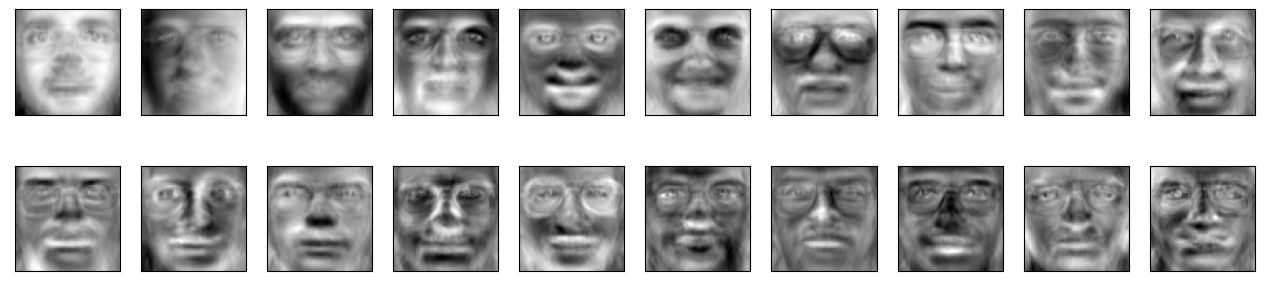

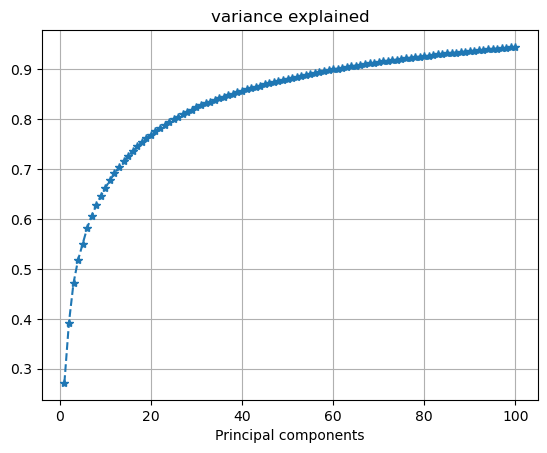

In [8]:
n_eigenfaces = 100
#plot eigenfaces
fig = plt.figure(figsize=(16,20))
for i in range(20):    
    ax = fig.add_subplot(10,10,i+1,xticks = [], yticks = [])    
    im = eigenVectors[:,i]
    ax.imshow(im.reshape(64,64),cmap = plt.cm.gray)
plt.show()
    
#plot cummulative variance explained    
summ = eigenValues.sum()
cumsum = 0
total_var_explained = np.zeros(n_eigenfaces)
for i in range(n_eigenfaces):    
    cumsum = cumsum + eigenValues[i]
    total_var_explained[i]=(cumsum/summ)
plt.plot(range(1,n_eigenfaces+1),total_var_explained,"--*")
plt.grid();
plt.title('variance explained')
plt.xlabel('Principal components')
plt.show();


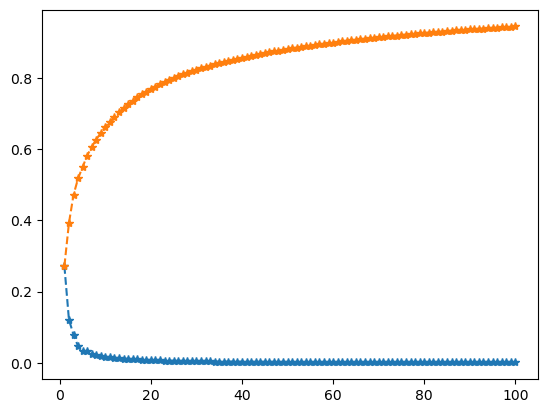

In [18]:
# COmputing corresponding eigenavlue divided by the sum og all eigevalues
eigenValues = eigenValues/np.sum(eigenValues)


# Inspecting the K = 100 most important eigenvalues
# Plot the cumulative percentage of variance explained k = 1,2,3,...,100
plt.plot(range(1,n_eigenfaces+1),total_var_explained,"--*")

**Answer:**

The features that are captured the nost by the eigenfaces are the eyes, the nose and the mouth. These features could also be seen as the most important for identifying a person.

It is obvious that they the more eigenfaces, the better quality and recognition. Looking at the plot, it appears that around 100 eigenfaces are needed to explain 90% of the variance. And merely 30 eigenfaces are needed to explain 80% of the variance.


# 6. Classification: Face recognition using eigenfaces

The following code projects the training data into the subspace generated by $K$ eigenfaces.

Cosine similarity between two images is defined as the cosine of the angle between them, that is, the dot product of the vectors divided by the product of their lengths.
The cosine similarity always belongs to the interval $[-1,1].$
The cosine similarity between the projected features of the training image (represented by a vector $A$) and the projected features of the test image (represented by a vector $B$), as:
$$ \text{similarity}(A,B) = {\mathbf {A} \cdot \mathbf {B}  \over \|\mathbf {A} \|\|\mathbf {B} \|}={\frac {\sum \limits _{i=1}^{K}{A_{i}B_{i}}}{{\sqrt {\sum \limits _{i=1}^{K}{A_{i}^{2}}}}{\sqrt {\sum\limits _{i=1}^{K}{B_{i}^{2}}}}}} $$

The term "cosine distance" is commonly used for the complement of cosine similarity in positive space, that is

$\text{cosine distance}(A,B) := 1 - \text{similarity}(A,B).$


- Once the code is running, explain how it works i.e. how it classifies an image.
- Modify the function called *classify_image* by implementing the cosine distance score, that uses the eigenface projection to classify images from the test data set $\tilde{\mathbf{X}}_\textrm{test}$.

$\qquad$  **Help**: In python the cosine distance is given by the spatial.distance.cosine function, such that the most similar training image can be found by:

        similarity_score = np.zeros(200)
        for n in range(200):
            A = subspace_features[:,n]
            similarity_score[n] = spatial.distance.cosine(A, B)
        most_similar_tranining_index = np.argmin(similarity_score)

(4096, 300)
(4096, 100)
test subject number : 28
predicted subject number : 28
classified corretly


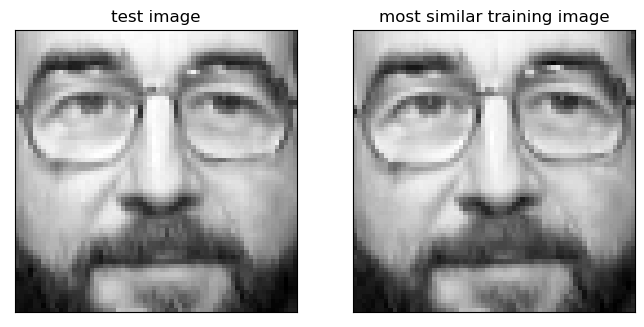

In [12]:
K = 20 #number of eigenfaces
subspace    = eigenVectors[:,:K]
X_train_z_  = X_train_z.T
X_test_z_   = X_test_z.T
print(X_train_z_.shape)
print(X_test_z_.shape)
#project the training data into the subspace generated by the eigenfaces
subspace_features = np.matmul(subspace.T,X_train_z_)

def classify_image(test_image_nr):
    input_im = (X_test_z_[:,test_image_nr])
    input_image_features = np.matmul(subspace.T,input_im)
    similarity_score = np.zeros(n_train_subjects)
    for n in range(n_train_subjects):
        A = subspace_features[:,n]
        similarity_score[n] = spatial.distance.cosine(A,input_image_features)
    most_similar_training_index = np.argmin(similarity_score)
    bestFitIndex = np.argmin(similarity_score)
    train_image_nr = y_train[bestFitIndex]
    return train_image_nr, bestFitIndex

#select a particular test image
test_image_nr = 20 
test_subject = y_test[test_image_nr]
#find the training image that is most similar
predict_subject, bestFitIndex = classify_image(test_image_nr)

#plot the two images
fig = plt.figure(figsize=(8,10))
ax = fig.add_subplot(1,2,1,xticks = [], yticks = [])    
ax.imshow(X_test[test_image_nr,:].reshape(64,64),cmap = plt.cm.gray)
ax.set_title('test image')
ax = fig.add_subplot(1,2,2,xticks = [], yticks = [])    
ax.imshow(X_train[bestFitIndex,:].reshape(64,64),cmap = plt.cm.gray)
ax.set_title('most similar training image')

#compute the test test predicted subject number
print('test subject number :', test_subject)
print('predicted subject number :', predict_subject)
if(test_subject == predict_subject):
    print('classified correctly')
else:
    print('miss-classification')

# 7. Now, we want to investigate how the number of eigenfaces influence the classification performance.
- Write code that uses the classifyImage function to classify all the 200 test images and simultaneously counts the number of miss-classified instances.

- Compute and plot the number of miss-classifications when using different number of eigenfaces $K$, for instance in the range $K\in[1,100]$. 

- Comment on the relation between explained variance (computed and plottet earlier for the training data) and the classification performance when varying $K$.   



**Answer:**

The expected variance and the classification performance are inversely proportional. The more eigenfaces are used, the better the classification performance. This is because the more eigenfaces are used, the more variance is explained. The more variance is explained, the better the classification performance.


- Try to plot the images that are miss-classified together with their most similar images. Comment on what features you expect the mis-classification to be caused by. Is it the same features that causes miss-classification of multiple images? 

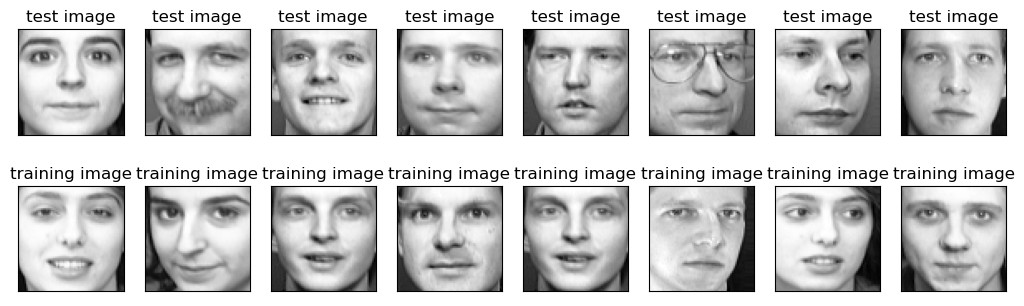

In [30]:
# Plot the miss-classified images with their most similar training image. The obvius tendency is that the pose of the people is signifant in the classification.
miss_classified = []
for i in range(len(y_test)):
    test_subject = y_test[i]
    predict_subject, bestFitIndex = classify_image(i)
    if(test_subject != predict_subject):
        miss_classified.append(i)

fig = plt.figure(figsize=(16,20))
for i in range(len(miss_classified)):
    test_image_nr = miss_classified[i]
    test_subject = y_test[test_image_nr]
    predict_subject, bestFitIndex = classify_image(test_image_nr)
    ax = fig.add_subplot(10,10,i+1,xticks = [], yticks = [])    
    ax.imshow(X_test[test_image_nr,:].reshape(64,64),cmap = plt.cm.gray)
    ax.set_title('test image')
    ax = fig.add_subplot(10,10,i+1+10,xticks = [], yticks = [])    
    ax.imshow(X_train[bestFitIndex,:].reshape(64,64),cmap = plt.cm.gray)
    ax.set_title('training image')




- Instead of basing the classification on the single most similar image, you can base it on a majority vote of the five most similar images. Compare and comment on the classification error using this procedure.

**Answer:**

The lighting and the angle of the face are the features that causes the miss-classification. The classification error is reduced by using a majority vote of the five most similar images. More answers later (:
 

100%|██████████| 100/100 [00:53<00:00,  1.88it/s]


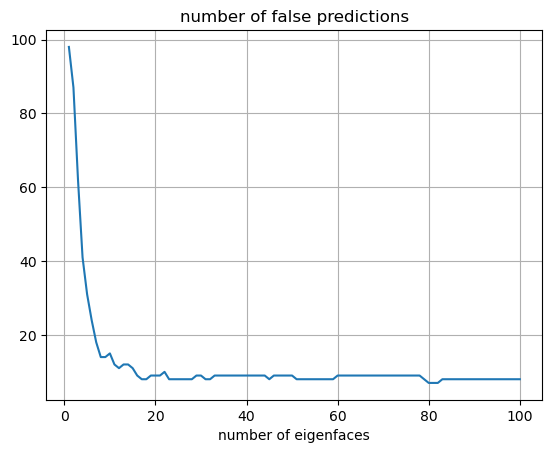

In [37]:
# ANSWER

# creating new classify function for the five most similar images
def classify_image_5(test_image_nr):
    input_im = (X_test_z_[:,test_image_nr])
    input_image_features = np.matmul(subspace.T,input_im)
    similarity_score = np.zeros(n_train_subjects)
    for n in range(n_train_subjects):
        A = subspace_features[:,n]
        similarity_score[n] = spatial.distance.cosine(A,input_image_features)
    most_similar_training_index = np.argmin(similarity_score)
    bestFitIndex = np.argsort(similarity_score)[:5]
    train_image_nr = y_train[bestFitIndex]
    return train_image_nr, bestFitIndex


    #compute prediction performance for different number of eigenfaces
false_predictions = np.zeros(100)
for k in tqdm(range(100)):   
    #set number of eigenfaces
    number_of_eigenfaces = k+1
    subspace = eigenVectors[:,:number_of_eigenfaces]
    #project the training data into the subspace generated by the eigenfaces
    subspace_features = np.matmul(subspace.T,X_train_z_)
    #iterate through all test images
    for i in range(n_test_subjects):
        test_subject    = y_test[i]
        predict_subject, bestFitIndex = classify_image(i)
        if test_subject != predict_subject:
            false_predictions[k] = false_predictions[k] + 1

#plot the prediction performance vs number of eigenfaces
plt.plot(range(1,n_test_subjects+1),false_predictions)
plt.grid()
plt.title('number of false predictions')
plt.xlabel('number of eigenfaces')
plt.show()

In [43]:
print(false_predictions) # number of false predictions for each number of eigenfaces decreasing with increasing number of eigenfaces

[98. 87. 62. 41. 31. 24. 18. 14. 14. 15. 12. 11. 12. 12. 11.  9.  8.  8.
  9.  9.  9. 10.  8.  8.  8.  8.  8.  8.  9.  9.  8.  8.  9.  9.  9.  9.
  9.  9.  9.  9.  9.  9.  9.  9.  8.  9.  9.  9.  9.  9.  8.  8.  8.  8.
  8.  8.  8.  8.  8.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.
  9.  9.  9.  9.  9.  9.  8.  7.  7.  7.  8.  8.  8.  8.  8.  8.  8.  8.
  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.]


- Instead of basing the classification on the single most similar image, you can base it on a majority vote of the five most similar images. Compare and comment on the classification error using this procedure.


**Answer:**

The classification error is reduced by using a majority vote of the five most similar images, this is because the five most similar images are more likely to be from the same person. Furthermore, it seems obvious that a larger sample of comparison images will give a better result than a smaller sample.

In [15]:
#compute prediction performance for different number of eigenfaces
false_predictions = np.zeros(100)
for k in tqdm(range(100)):   
    #set number of eigenfaces
    number_of_eigenfaces = k+1
    subspace = eigenVectors[:,:number_of_eigenfaces]
    #project the training data into the subspace generated by the eigenfaces
    subspace_features = np.matmul(subspace.T,X_train_z_)
    #iterate through all test images
    for i in range(n_test_subjects):
        test_subject    = y_test[i]
        predict_subject, bestFitIndex = classify_image(i)
        if test_subject != predict_subject:
            false_predictions[k] = false_predictions[k] + 1


100%|██████████| 100/100 [00:52<00:00,  1.90it/s]


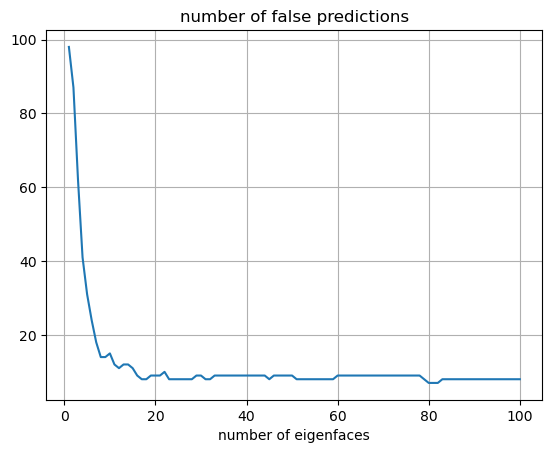

In [16]:
#plot the prediction performance vs number of eigenfaces
plt.plot(range(1,n_test_subjects+1),false_predictions)
plt.grid()
plt.title('number of false predictions')
plt.xlabel('number of eigenfaces')
plt.show()
